#**Projet 07 - Implémentez un modèle de scoring**

PLAN :

**I. Importation des librairies et chargement des données**

**II. Traitements divers**
1. Appliquer une réduction de dimension
2. Imputation
3. Suppression des colonnes non utiles

**III. Baseline**
1. Sépération X et Y
2. Dummy classifier

**IV. Modélisation**
1. Méthode pour éviter le déséquilibre des classes
2. Optimisation des hyper paramètres
3. Execution des modèles (Random Forest,  XGBoost, LightGBM, LightGBM bank)
4. Comparaison et sélection du meilleur modèle

**V. Importance des features**

**VI. Conclusion**



##**I. Importation des librairies et chargement des données**

In [ ]:
#Importer les librairies utiles à notre analyse

#Création de dataframe
import pandas as pd

#Création de calculs complexes 
import numpy as np

# Tracer des graphiques et visualiser des données
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import seaborn as sns

# google drive
from google.colab import drive

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sklearn processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Sklearn classification algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Sklearn classification model evaluation functions
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

!pip install shap 
import shap
! pip install lime
import lime
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["ok","default"])

from sklearn.dummy import DummyClassifier

from sklearn.utils import resample

import pickle

import time
%matplotlib inline
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Chargement des données
app_enc = pd.read_csv('/content/drive/MyDrive/app_enc.csv')

In [ ]:
app_enc.shape

(356251, 798)

##**II. Traitements divers**

###**1. Réduction de dimension**

In [ ]:
app_enc = app_enc.sample(50000)
pca = PCA()
scaler_text = StandardScaler()
pca.fit(scaler_text.fit_transform(app_enc.fillna(0).replace([-np.inf, np.inf],0)))

PCA()

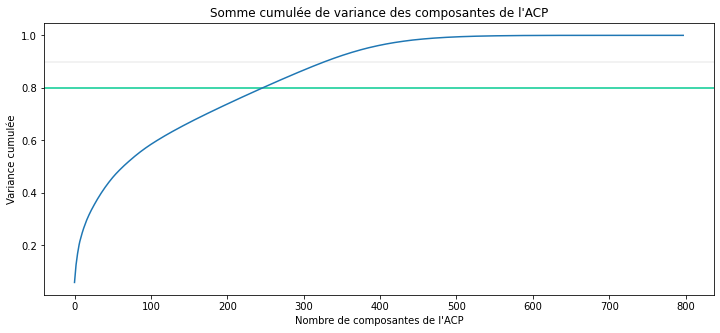

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Somme cumulée de variance des composantes de l\'ACP')
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')
plt.axhline(y=0.8, color='#02CA91', linestyle='-')
plt.axhline(y=0.9, color='#efefef', linestyle='-')
plt.plot(list(range(app_enc.shape[1])),
         np.cumsum(pca.explained_variance_ratio_))

Sur les 798 variables sélectionnées, nous constatons qu'environ 250 peuvent couvrir une inertie de 80%.

In [ ]:
app_enc.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,...,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
318176,10669,177558,NaN,1,0,1,0,112500.0,331920.0,14751.0,225000.0,0.018850,-13774,-3999.0,-5651.0,-4486,NaN,1,1,0,1,0,1,2.0,2,2,10,0,0,0,0,0,0,0.285588,0.483880,0.547810,0.0928,0.1087,0.9841,0.7824,...,1.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
122423,122426,241940,0.0,0,1,1,0,202500.0,1546020.0,45333.0,1350000.0,0.020246,-19280,NaN,-6910.0,-2838,3.0,1,0,0,1,1,0,2.0,3,3,11,0,0,0,0,0,0,0.622528,0.431991,0.624615,0.0773,0.0784,0.9861,0.8096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54260,54262,162866,0.0,0,1,0,0,270000.0,2517300.0,66532.5,2250000.0,0.010006,-20960,NaN,-10927.0,-4472,6.0,1,0,0,1,0,0,2.0,2,2,9,0,0,0,0,0,0,0.661741,0.683433,0.475850,0.2165,0.1583,0.9851,0.7960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180258,180261,308899,0.0,0,0,1,0,270000.0,405000.0,32125.5,405000.0,0.035792,-12943,-2941.0,-422.0,-1994,NaN,1,1,1,1,0,0,1.0,2,2,15,0,0,0,0,0,0,0.265336,0.705052,0.298595,NaN,NaN,NaN,NaN,...,1.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
76590,76592,188819,0.0,0,0,0,0,171000.0,562500.0,27189.0,562500.0,0.014520,-14517,-603.0,-7287.0,-3698,NaN,1,1,0,1,0,0,2.0,2,2,13,0,0,0,0,1,1,NaN,0.474477,0.472253,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###**2. Imputation**

Pourcentage de Nan dans le dataset

In [ ]:
app_enc.isna().sum().sum()/app_enc.size

0.25353558897243106

In [ ]:
column_with_nan = app_enc.columns[app_enc.isnull().any()]

Suppression des colonnes avec plus de 70% de Nan

In [ ]:
for column in column_with_nan:
     if app_enc[column].isnull().sum()*100.0/app_enc.shape[0] > 70:
             app_enc.drop(column,1, inplace=True)
 

In [ ]:
app_enc.shape

(50000, 646)

In [ ]:
app_enc.isna().sum().sum()/app_enc.size

0.14128

Gestion des infinis et des Nan

In [ ]:
# Remplacer les chiffres inifis par nan, puis remplacer par 0
app_enc.replace([np.inf, -np.inf], np.nan, inplace=True)
app_enc.fillna(0, inplace=True)

In [ ]:
# Suppression des colonnes non utiles au projet
app_enc.drop(columns=['index'],inplace=True)

In [ ]:
app_enc.isna().sum().sum()/app_enc.size

0.0

##**III. Baseline**

###**1. Séparation X et Y**

In [ ]:
# Découpage originale
sample = app_enc#.sample(100000)
#sans nan
app_enc_train = sample[~app_enc["TARGET"].isnull()]

In [ ]:
#avec nan
# app_enc_test = sample[app_enc["TARGET"].isnull()]
# export_test = app_enc_test.drop(columns="TARGET")

In [ ]:
y = app_enc_train["TARGET"].copy()
X = app_enc_train.copy().drop(columns="TARGET")

In [ ]:
del app_enc
del app_enc_train
gc.collect()

377

In [ ]:
# Standardisation des colonnes numériques

#Identification des colonnes numériques
numerical_columns = X.select_dtypes(['int32','float64', "int64"]).columns
numerical_columns = numerical_columns.drop("SK_ID_CURR")

#Normalisation avec Minmax
mm = MinMaxScaler(feature_range = (0, 1))
X[numerical_columns] = mm.fit_transform(X[numerical_columns])

In [ ]:
X.to_csv('/content/drive/MyDrive/app_sample.csv', index=False)
X.drop(columns=['SK_ID_CURR'],inplace=True)

###**2. Tester un modèle Dummy Classifier sur les données**

1 : défaut de paiement / 0 : bon payeur
- Faux positifs : identifé mauvais payeur alors que bon payeur
- Faux négatifs : identifié bon payeur alors que mauvais payeur
- Vrais positifs : vrai mauvais payeur identifié
- Vrais négatifs : vrai bon payeur identifié

Scoring sélectionnés :
- **Precision**: la proportion de prédictions correctes parmi les points que l’on a prédits positifs TP/ TP+FP. C’est la capacité de notre modèle à ne déclencher d’alarme que pour un vrai incendie. 

- **Recall** : est le taux de vrais positifs, c’est à dire la proportion de positifs que l’on a correctement identifiés.  TP/ TP+FN. C’est la capacité de notre modèle à détecter tous les incendies.

- **F-mesure**: Pour évaluer un compromis entre rappel et précision, on peut calculer la "F-mesure", qui est leur moyenne harmonique.

- **AUC**  : The AUC provides a numerical measure for comparing ROC curves. A value of 1 indicates a model that perfectly separates the classes.

- **Acuracy** :  il indique le pourcentage de bonnes prédictions : à max 



In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

def predict_and_outputscore(model, model_name, X_test, y_test, threshold=0.5):
  # predict_proba va nous retourner des probabilités
  y_res = model.predict_proba(X_test)
  # transform_with_threshold va transformer les probabilités de y_res en 0 (pas de défaut) ou 1 (défaut de paiement) 
  # en appliquant le seuil de prédiction de défaut de paiement à la valeur threshold
  y_predict = transform_with_threshold(y_res, threshold)
  roc_auc = roc_auc_score(y_test, y_predict)
  f1 = f1_score(y_test, y_predict)
  precision = precision_score(y_test, y_predict)
  recall = recall_score(y_test, y_predict)
  confusion = confusion_matrix(y_test, y_predict)
  accuracy = accuracy_score (y_test, y_predict)

  print(model_name + " f1: " + str(f1))
  print(model_name + " roc_auc: " + str(roc_auc))
  print(model_name + " precision: " + str(precision))
  print(model_name + " recall: " + str(recall))
  print(model_name + " confusion: " + str(confusion))
  print(model_name + " accuracy: " + str(accuracy))

  return y_res, roc_auc, f1, precision, recall, confusion, accuracy

In [ ]:
# transformer le vecteur de probabilité en un vecteur de prédiction
# prend un vecteur y_proba qui contient des valeurs de type ([0.1 0.9], [0.2 0.8]) pour les transformer en un vecteur de prediction de type (1 0) en appliquant la valeur de seuil sur la probabilité de défaut de paiment
# c-à-d sur 0.9 et 0.8 par ex.
def transform_with_threshold(y_proba, threshold):
  y_predict = (pd.DataFrame(y_proba)[1] > threshold).astype(int).values
  return y_predict

In [ ]:
modeles_dict = {}

In [ ]:
# baseline avec dummy classifier 
# choisir most_frequent, la classe la plus fréquente à 92% (classe majoritaire) acuracy pas la meilleure metric
X_train, X_test, y_train, y_test = \
                        train_test_split(X,
                                         y,
                                         test_size = 0.1,
                                         random_state = 42
                                        )
                        
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)

(y_res, roc_auc, f1, precision, recall, confusion, accuracy) = predict_and_outputscore(dummy_classifier, "Dummy Classifier", X_test, y_test)
modeles_dict["Dummy Classifier"] = (roc_auc, f1, precision, recall, accuracy)
# dummy_classifier.score(X_test, y_res)

Dummy Classifier f1: 0.0
Dummy Classifier roc_auc: 0.5
Dummy Classifier precision: 0.0
Dummy Classifier recall: 0.0
Dummy Classifier confusion: [[4682    0]
 [ 318    0]]
Dummy Classifier accuracy: 0.9364


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
X_train.shape

(45000, 643)

In [ ]:
X_test.shape

(5000, 643)

**Limite de l'accuracy** 

Selon le score de l'accuracy, le modèle prédirait à 91%. Or cela peut s'expliquer par le déséquilibre des classes.

In [ ]:
# Define a function to plot the ROC/AUC
def plotRocAuc(model, X, y):
    
    probabilities = model.predict_proba(X)
    probabilities = probabilities[:, 1]  # keep probabilities for first class only
        
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y, probabilities)    
    
    # Plot the "dumb model" line
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    # Plot the model line
    plt.plot(fpr, tpr, marker='.')
    plt.text(0.75, 0.25, "AUC: " + str(round(roc_auc_score(y, probabilities),2)))
    
    # show the plot
    plt.show()

##**IV. Modélisation**

###**1. Techniques pour éviter le déséquilibre des classes**

Mettre en place plusieurs méthodes et les comparer pour contrecarrer le problème d'équilibre des classes et tester avec le modèle déjà existant, en utilisant les métriques: f1-score, precision, recall, confusion matrix et AUC score.
- **SMOTE**

- **Resampling**

- **Intrinsèque** jouer sur les paramètres Random Forest et LigtGBM

####**1.1 Resampling**

Le resampling consiste à retirer des échantillons de la classe majoritaire (sous-échantillonnage) et/ou à ajouter plus d'exemples de la classe minoritaire (sur-échantillonnage).

In [ ]:
#https://openclassrooms.com/fr/courses/6401081-improve-the-performance-of-a-machine-learning-model/6519011-evaluate-the-performance-of-a-classification-model

# Put X and y training data back together again
Xy_train = pd.concat([X, y], axis=1)

# Split into default and nodefault
Xy_train_nodefault = Xy_train[Xy_train.TARGET==0]
Xy_train_default = Xy_train[Xy_train.TARGET==1]

# Count the nodefault cases
Xy_train_nodefault_count = Xy_train_nodefault.shape[0]
print("no default " + str(Xy_train_nodefault_count))

# Count the default cases
Xy_train_default_count = Xy_train_default.shape[0]
Xy_train_default_count
print("default " + str(Xy_train_default_count))

no default 46540
default 3460


In [ ]:
# Oversample default
Xy_train_default_oversampled = resample(Xy_train_default, replace=True, n_samples=Xy_train_nodefault_count)

# Combine the two classes
combined = pd.concat([Xy_train_default_oversampled, Xy_train_nodefault])

# Show that we how have balanced classes
combined.TARGET.value_counts()

# Re-split the training data
y_resampled = combined.TARGET
X_resampled = combined.drop('TARGET', axis=1)

In [ ]:
# nombre de samples positifs
(y_resampled == 1).sum()

46540

In [ ]:
# nombre de samples négatifs
(y_resampled == 0).sum()

46540

In [ ]:
del Xy_train
del Xy_train_nodefault
del Xy_train_default
del Xy_train_nodefault_count
del Xy_train_default_count
del Xy_train_default_oversampled
gc.collect()

191

####**1. 2 SMOTE**

Synthetic Minority Oversampling Technique fonctionne en choisissant au hasard un point de la classe minoritaire et en calculant les k plus proches voisins pour ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins.

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

smote = SMOTE()
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_train, y_train)

# print('Original dataset shape', Counter(y))
# print('Resample dataset shape', Counter(y_ros))

In [ ]:
# nombre de samples positifs
(y_smote == 1).sum()

41858

In [ ]:
# nombre de samples négatifs
(y_smote == 0).sum()

41858

### **2. Optimisation pour le choix des hyperparamètres**

####**2. 1 Choix des modèles**

- Random Forest 
- XG Boost 
- LightGBM 

ETAPES :
- faire StratifiesKFold
- Faire cross Validation
- Varier les valeurs des paramètres avec Hyperopt
- Afficher les best paramètres
- Entrainement des modèles sur tout le jeu de données


####**2. 2 Choix des hyperparamètres**

Pour utiliser Hyperopt, nous devons spécifier quatre éléments clés pour notre modèle :
1. Fonction objectif | Cela devrait renvoyer la valeur que nous voulons minimiser pendant le calcul. Dans notre cas, il s'agit de la fonction 'accuracy_score'.
2. Espace de recherche | Cela définit la plage de valeurs qu'un hyperparamètre donné peut prendre. Il peut s'agir d'entiers, de flottants ou de chaînes comme nous le verrons plus loin dans l'article.
3. Algorithme de réglage | Dans Hyperopt, il existe deux principaux algorithmes de recherche d'hyperparamètres : la recherche aléatoire et les estimateurs d'arbre de Parzen (bayésien). Dans cet exemple, nous utiliserons ce dernier car il est connu pour produire les meilleurs résultats.
4. Évaluations | Cela fait référence au nombre d'instances d'hyperparamètres différentes sur lesquelles entraîner le modèle. Il est recommandé qu'il soit compris entre 10 et 30 fois le nombre d'hyperparamètres définis dans l'espace de recherche pour optimiser les performances et le temps de calcul.


**Création d'une métrique**

La métrique Cost normalized consiste à calculer le gain obtenu pour l'ensemble des clients

Pour cela nous avons fixé un poids arbitraire pour chacune des prédictions relativement à leurs valeurs réelles.

Les valeurs des poids sont les suivantes :

Correction : minimiser une fonction de coût
- fn_value (mauvais payeur identifié bon payeur) = 10
- tp_value = 0
- tn_value = 0
- fp_value (bon payeur identifié comme mauvais payeur : manque à gagner) = 1

In [ ]:
# on met des paramètres pour minimiser les faux 
def normalized_bank_cost(y, y_pred, fn_val=10, fp_val=1, auc_val=0):
  #AUC_val = 0
    confusion = confusion_matrix(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    # true negatives : des bon payeurs correctement identifiés
    tn = confusion[0, 0]
    # false negatives : des mauvais payeurs identifiés en bon payeur
    fn = confusion[1, 0]
    # false positives : bon payeurs identifiés comme mauvais
    fp = confusion[0, 1]
    # true positives : mauvais payeurs correctement identifiés
    tp = confusion[1, 1]

    return fn*fn_val + fp*fp_val + auc*auc_val

**Fonction Hyperopt**

In [ ]:
# https://ichi.pro/fr/optimisez-votre-reglage-d-hyperparametres-avec-hyperopt-147426684149429
# Utiliser Hyperopt

In [ ]:
# read in hyperopt values
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

In [ ]:
# set the hyperparam tuning algorithm
algorithm=tpe.suggest

# une fonction qui créé une fonction utilisable par hyperopt
# méthode qui va utiliser le folding pour entrainer le modèle pour chaque fold 
# ... et prendre la moyenne du score de chacun des fold entrainé
# search space : utilisé pour l'optimisation des paramètres (espace d'intervalle)

# x_smote, y_smote
def optimize_function(model_alg, folding, model_name, scoring, intr=None):
  def optimize(search_space):
    model = model_alg(**search_space["params"])
    if(search_space["sampling"] == "smote"):
      x_fold = x_smote
      y_fold = y_smote
    else:
      x_fold = X_resampled
      y_fold = y_resampled
    scores = []
    
    for train_index, test_index in folding.split(x_fold, y_fold):
      x_training_set, y_training_set = x_fold.iloc[train_index], y_fold.iloc[train_index]
      x_test_set, y_test_set = x_fold.iloc[test_index], y_fold.iloc[test_index]
      model.fit(x_training_set, y_training_set)
      y_proba = model.predict_proba(x_test_set)
      y_predict = (pd.DataFrame(y_proba)[1] > search_space["threshold"]).astype(int).values
      scores.append(scoring(y_test_set, y_predict))
    
    return {'loss': np.mean(scores), 'status': STATUS_OK}
    
  return optimize

In [ ]:
#Folding
skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)
kf = KFold(n_splits= 5, shuffle=True, random_state=1001)

###**3. Execution et optimisation des différents modèles**

In [ ]:
def inverted_f1_score(*args):
  return -1 * f1_score(*args)
def inverted_roc_auc_score(*args):
  return -1 * roc_auc_score(*args)

In [ ]:
random_forest_optimize = optimize_function(RandomForestClassifier, skf, "RandomForestClassifier", inverted_roc_auc_score)
random_forest_optimize_bank = optimize_function(RandomForestClassifier, skf, "RandomForestClassifier", normalized_bank_cost)
lgbm_optimize = optimize_function(LGBMClassifier, skf, "LGBMClassifier", inverted_roc_auc_score)
lgbm_optimize_bank = optimize_function(LGBMClassifier, skf, "LGBMClassifier", normalized_bank_cost)
xgb_optimize = optimize_function(XGBClassifier, skf, "XGBClassifier", inverted_roc_auc_score)

####**3. 1 Random Forest**

In [ ]:
# sample_weight in fit
search_space_rf = {
    'params': 
    {
      'n_estimators':hp.randint('n_estimators',100)+1,            
      'max_depth': hp.randint('max_depth',100)+1,
      'min_samples_split':hp.uniform('min_samples_split',0,1),
      'min_samples_leaf':hp.randint('min_samples_leaf',10)+1,  
      'criterion':hp.choice('criterion',['gini','entropy']),    
      'max_features':hp.choice('max_features',['sqrt', 'log2'])
    },
    'threshold': hp.uniform('threshold',0.4,0.6),
    'sampling':hp.choice('sampling',['resampling','smote']),
  # "sample_intra_param": {"sample_weight":[]}
}

In [ ]:
# execution du modèle
best_params_rf = fmin(fn=random_forest_optimize, space=search_space_rf, algo=algorithm, max_evals=10)
#best_params_rf_bank = fmin(fn=random_forest_optimize_bank, space=search_space_rf, algo=algorithm, max_evals=10)

100%|██████████| 10/10 [03:58<00:00, 23.85s/it, best loss: -0.7998234382882728]


In [ ]:
# Meilleurs paramètres Random Forest 
best_params_rf_eval = space_eval(search_space_rf, best_params_rf)
best_params_rf_eval

{'params': {'criterion': 'entropy',
  'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 9,
  'min_samples_split': 0.06115200948684141,
  'n_estimators': 69},
 'sampling': 'smote',
 'threshold': 0.47193641944835807}

In [ ]:
# Meilleurs paramètres Random Forest avec la metrique bank
# best_params_rf_bank_eval = space_eval(search_space_rf, best_params_rf_bank)
# best_params_rf_bank_eval

In [ ]:
#Obtenir le temps d'execution
start = time.time()

if(best_params_rf_eval["sampling"] == "resampling"):
  x_fit = X_resampled
  y_fit = y_resampled
else:
  x_fit = x_smote
  y_fit = y_smote

rf_model = RandomForestClassifier(**best_params_rf_eval["params"])
rf_model.fit(x_fit, y_fit)
trainend = time.time()
print("Temps d'entrainement: " + str(trainend - start))
(y_res_rf, roc_auc_rf, f1_rf, precision_rf, recall_rf, confusion_rf, accuracy_rf) = predict_and_outputscore(rf_model, "RandomForestClassifier", X_test, y_test, best_params_rf_eval["threshold"])
modeles_dict["RandomForestClassifier"] = (roc_auc_rf, f1_rf, precision_rf, recall_rf, accuracy_rf)

confusion_rf = confusion_rf.astype(np.float)
confusion_rf[0] = (confusion_rf[0]/confusion_rf[0].sum())
confusion_rf[1] = (confusion_rf[1]/confusion_rf[1].sum())
print("Temps total: " + str(time.time() - start))
print("Temps de prédiction: " + str(time.time() - trainend))

Temps d'entrainement: 28.965593099594116
RandomForestClassifier f1: 0.15061728395061727
RandomForestClassifier roc_auc: 0.5658093756632521
RandomForestClassifier precision: 0.09370199692780339
RandomForestClassifier recall: 0.3836477987421384
RandomForestClassifier confusion: [[3502 1180]
 [ 196  122]]
RandomForestClassifier accuracy: 0.7248
Temps total: 29.038452863693237
Temps de prédiction: 0.07323718070983887


In [ ]:
y_res_rf

array([[0.51344173, 0.48655827],
       [0.40929844, 0.59070156],
       [0.70655754, 0.29344246],
       ...,
       [0.7644958 , 0.2355042 ],
       [0.41400312, 0.58599688],
       [0.63624805, 0.36375195]])

Text(0.5, 1.0, 'Confusion matrix')

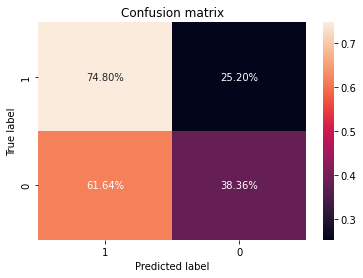

In [ ]:
# matrice de confusion

sns.heatmap(confusion_rf, annot=True, fmt='.2%', cbar=True)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')


Explication : 
- 95% des défauts de paiement ont été correctement prédits / 5% des mauvais payeurs ont été identifiés comme bon payeurs
- 15 % de non défaut de paiement ont été correctement prédits / 85 % des bon payeurs ont été qualifiés de défaut de paiement 

####**3. 2 XGBoost**

In [ ]:
# Number_of_positives = (y_test == 1).sum()
# Number_of_negatives = (y_test == 0).sum()
# scale_pos_weight = Number_of_negatives/Number_of_positives)
 # "sample_intra_param": {"sample_weight":[]}

search_space_xgboost = {
    'params': 
    {
      'learning_rate': hp.uniform('learning_rate',0,1), 
      'max_depth': hp.randint('max_depth',5)+1,
      'n_estimators': hp.randint('n_estimators',2)+930,
      'num_leaves' : hp.randint('num_leaves',10)+30,
      'colsample_bytree': hp.uniform('colsample_bytree',0,1), 
      'subsample' : hp.uniform('subsample',0,1),
      'reg_alpha' : hp.uniform('reg_alpha',0,1),  
      'reg_lambda' : hp.uniform('reg_lambda',0,1),  
      'min_split_gain' : hp.uniform('min_split_gain',0,1), 
      'min_child_weight' : hp.uniform('min_child_weight',30,40), 
    },
    'threshold': hp.uniform('threshold',0.4,0.6),
    'sampling':hp.choice('sampling',['resampling','smote']),
    # "sample_intra_param": {"scale_pos_weight":Number_of_negatives/Number_of_positives}
}

In [ ]:
# recherche des meilleurs paramètres

best_params_xg = fmin(fn=xgb_optimize, space=search_space_xgboost, algo=algorithm, max_evals=10)

100%|██████████| 10/10 [6:45:33<00:00, 2433.32s/it, best loss: -0.9685646755479158]


In [ ]:
# Meilleurs paramètres XGBoost 
best_params_xg_eval = space_eval(search_space_xgboost, best_params_xg)
best_params_xg_eval
# 'threshold': 0.4761934733866644 <= le meilleur seuil de qualification en défaut de paiement est à partir de 0.47

{'params': {'colsample_bytree': 0.19148255010098425,
  'learning_rate': 0.47503554065231157,
  'max_depth': 4,
  'min_child_weight': 36.334031142812876,
  'min_split_gain': 0.21294618277792632,
  'n_estimators': 930,
  'num_leaves': 34,
  'reg_alpha': 0.3401996402360712,
  'reg_lambda': 0.3690759337499333,
  'subsample': 0.851090453999259},
 'sampling': 'resampling',
 'threshold': 0.45307908401165375}

In [ ]:
start = time.time()

if(best_params_xg_eval["sampling"] == "resampling"):
  x_fit = X_resampled
  y_fit = y_resampled
else:
  x_fit = x_smote
  y_fit = y_smote


XGBC_model = XGBClassifier(**best_params_xg_eval["params"])
XGBC_model.fit(x_fit, y_fit)
trainend = time.time()
(y_res_xg, roc_auc_xg, f1_xg, precision_xg, recall_xg, confusion_xg, accuracy_xg) = predict_and_outputscore(XGBC_model, "XGBCClassifier", X_test, y_test, best_params_xg_eval["threshold"])
print("Bank score : " + str(normalized_bank_cost(y_test, transform_with_threshold(y_res_xg, 0.5))))
modeles_dict["XGBCClassifier"] = (roc_auc_xg, f1_xg, precision_xg, recall_xg, accuracy_xg)
confusion_xg = confusion_xg.astype(np.float)
confusion_xg[0] = (confusion_xg[0]/confusion_xg[0].sum())
confusion_xg[1] = (confusion_xg[1]/confusion_xg[1].sum())

print("Temps total: " + str(time.time() - start))
print("Temps de prédiction: " + str(time.time() - trainend))

XGBCClassifier f1: 0.9408284023668639
XGBCClassifier roc_auc: 0.9957283212302435
XGBCClassifier precision: 0.888268156424581
XGBCClassifier recall: 1.0
XGBCClassifier confusion: [[4642   40]
 [   0  318]]
XGBCClassifier accuracy: 0.992
Bank score : 27.0
Temps total: 520.3604784011841
Temps de prédiction: 0.38747668266296387


Text(0.5, 1.0, 'Confusion matrix')

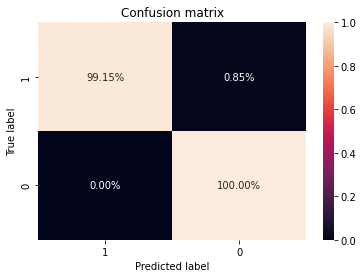

In [ ]:
# matrice de confusion

sns.heatmap(confusion_xg, annot=True, fmt='.2%', cbar=True)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')


####**3. 3 LightGBM**

In [ ]:
best_params_lgbm = fmin(fn=lgbm_optimize, space=search_space_xgboost, algo=algorithm, max_evals=10)
best_params_lgbm_bank = fmin(fn=lgbm_optimize_bank, space=search_space_xgboost, algo=algorithm, max_evals=10)

100%|██████████| 10/10 [41:21<00:00, 248.18s/it, best loss: 582.0]


In [ ]:
# Meilleurs paramètres lightGBM

best_params_lgbm_eval = space_eval(search_space_xgboost, best_params_lgbm)
best_params_lgbm_eval

{'params': {'colsample_bytree': 0.6962179216919926,
  'learning_rate': 0.6242470478335127,
  'max_depth': 3,
  'min_child_weight': 37.29927760668633,
  'min_split_gain': 0.08485001494481059,
  'n_estimators': 930,
  'num_leaves': 33,
  'reg_alpha': 0.2545033476590577,
  'reg_lambda': 0.6371738706313171,
  'subsample': 0.6088886751473388},
 'sampling': 'resampling',
 'threshold': 0.5099133836315484}

In [ ]:
# Meilleurs paramètres lightGBM avec bank metric
best_params_lgbm_bank_eval = space_eval(search_space_xgboost, best_params_lgbm_bank)
best_params_lgbm_bank_eval

{'params': {'colsample_bytree': 0.40129630648761583,
  'learning_rate': 0.521925409213364,
  'max_depth': 5,
  'min_child_weight': 36.36790855219478,
  'min_split_gain': 0.7653504354182105,
  'n_estimators': 931,
  'num_leaves': 35,
  'reg_alpha': 0.7405116500815483,
  'reg_lambda': 0.09859887985145921,
  'subsample': 0.831006810376344},
 'sampling': 'resampling',
 'threshold': 0.5538505437835136}

In [ ]:
# Execution du modèle
start = time.time()

if(best_params_lgbm_eval["sampling"] == "resampling"):
  x_fit = X_resampled
  y_fit = y_resampled
else:
  x_fit = x_smote
  y_fit = y_smote

lgbm_model = LGBMClassifier(**best_params_lgbm_eval["params"])
lgbm_model.fit(x_fit, y_fit)
trainend = time.time()
(y_res_lgmb, roc_auc_lgmb, f1_lgmb, precision_lgmb, recall_lgmb, confusion_lgmb, accuracy_lgmb) = predict_and_outputscore(lgbm_model, "LGBMClassifier", X_test, y_test, best_params_lgbm_eval["threshold"])
print("Bank score : " + str(normalized_bank_cost(y_test, transform_with_threshold(y_res_lgmb, 0.5))))
modeles_dict["LGBMClassifier"] = (roc_auc_lgmb, f1_lgmb, precision_lgmb, recall_lgmb, accuracy_lgmb)
confusion_lgmb = confusion_lgmb.astype(np.float)
confusion_lgmb[0] = (confusion_lgmb[0]/confusion_lgmb[0].sum())
confusion_lgmb[1] = (confusion_lgmb[1]/confusion_lgmb[1].sum())

print("Temps total: " + str(time.time() - start))
print("Temps de prédiction: " + str(time.time() - trainend))

LGBMClassifier f1: 0.9085714285714286
LGBMClassifier roc_auc: 0.9931653139683896
LGBMClassifier precision: 0.8324607329842932
LGBMClassifier recall: 1.0
LGBMClassifier confusion: [[4618   64]
 [   0  318]]
LGBMClassifier accuracy: 0.9872
Bank score : 71.0
Temps total: 88.29904532432556
Temps de prédiction: 0.319699764251709


Text(0.5, 1.0, 'Confusion matrix')

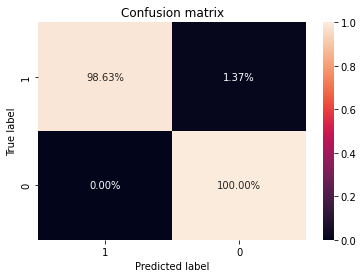

In [73]:
# matrice de confusion

sns.heatmap(confusion_lgmb, annot=True, fmt='.2%', cbar=True)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

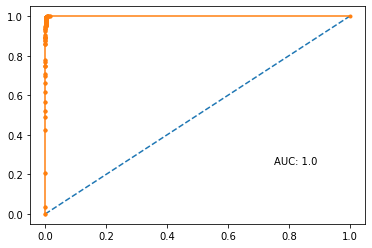

In [72]:
plotRocAuc(lgbm_model, X_train, y_train)

####**3. 4 LightGBM avec la métrique bank**

In [ ]:
start = time.time()

if(best_params_lgbm_eval["sampling"] == "resampling"):
  x_fit = X_resampled
  y_fit = y_resampled
else:
  x_fit = x_smote
  y_fit = y_smote

lgbm_model_bank = LGBMClassifier(**best_params_lgbm_bank_eval["params"])
lgbm_model_bank.fit(x_fit, y_fit)
(y_res_lgmb, roc_auc_lgmb, f1_lgmb, precision_lgmb, recall_lgmb, confusion_lgmb_bank, accuracy_lgmb) = predict_and_outputscore(lgbm_model_bank, "LGBMClassifier", X_test, y_test, best_params_lgbm_bank_eval["threshold"])
print("Bank score : " + str(normalized_bank_cost(y_test, transform_with_threshold(y_res_lgmb, 0.5))))

modeles_dict["LGBMClassifier (Bank)"] = (roc_auc_lgmb, f1_lgmb, precision_lgmb, recall_lgmb, accuracy_lgmb)
confusion_lgmb_bank = confusion_lgmb_bank.astype(np.float)
confusion_lgmb_bank[0] = (confusion_lgmb_bank[0]/confusion_lgmb_bank[0].sum())
confusion_lgmb_bank[1] = (confusion_lgmb_bank[1]/confusion_lgmb_bank[1].sum())

print("Temps total: " + str(time.time() - start))
print("Temps de prédiction: " + str(time.time() - trainend))

LGBMClassifier f1: 0.9366715758468336
LGBMClassifier roc_auc: 0.9954079453225118
LGBMClassifier precision: 0.8808864265927978
LGBMClassifier recall: 1.0
LGBMClassifier confusion: [[4639   43]
 [   0  318]]
LGBMClassifier accuracy: 0.9914
Bank score : 56.0
Temps total: 54.02891826629639
Temps de prédiction: 57.5986328125


Text(0.5, 1.0, 'Confusion matrix')

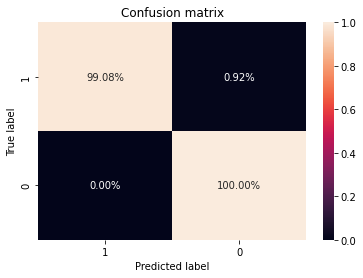

In [71]:
# Matrice de confusion

sns.heatmap(confusion_lgmb_bank, annot=True, fmt='.2%', cbar=True)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

####**3.5 Comparaison et sélection du meilleur modèle**

**Comparaison des scores sur les différents modèles**

In [ ]:
def plot_dict(dict):
  resultsDataFrame = pd.DataFrame.from_dict(dict, orient='index', columns=["roc_auc", "f1", "precision", "recall", "accuracy"])
  targetDataFrame = resultsDataFrame.reset_index().rename(columns={'index':"Model"}).melt(id_vars='Model', value_vars=['roc_auc', 'f1', 'precision', 'recall', 'accuracy'])
  plt.figure(figsize=(15,5))
  splot = sns.barplot(data=targetDataFrame, hue="variable", x="Model", y="value", palette="husl")
  for p in splot.patches: 
      splot.annotate('{:.2f}'.format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   size=10, 
                   xytext=(0, -12), 
                   textcoords='offset points') 

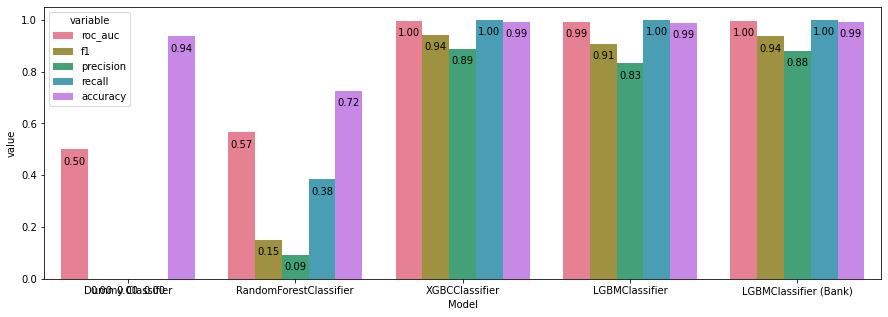

In [ ]:
plot_dict(modeles_dict)

In [ ]:
modeles_dict

{'Dummy Classifier': (0.5, 0.0, 0.0, 0.0, 0.9364),
 'LGBMClassifier': (0.9931653139683896,
  0.9085714285714286,
  0.8324607329842932,
  1.0,
  0.9872),
 'LGBMClassifier (Bank)': (0.9954079453225118,
  0.9366715758468336,
  0.8808864265927978,
  1.0,
  0.9914),
 'RandomForestClassifier': (0.5658093756632521,
  0.15061728395061727,
  0.09370199692780339,
  0.3836477987421384,
  0.7248),
 'XGBCClassifier': (0.9957283212302435,
  0.9408284023668639,
  0.888268156424581,
  1.0,
  0.992)}

Suite aux modélisations nous pouvons dire que **LightGBM est le meilleur modèle** pour évaluer la solvabilité des clients. Il a des scores comparables à celui de XGBoost, en étant légèrement meilleur, mais il est aussi plus rapide au niveau du temps d'exécution. 


##**V. Importance des features** 

###**1. TOP features** 

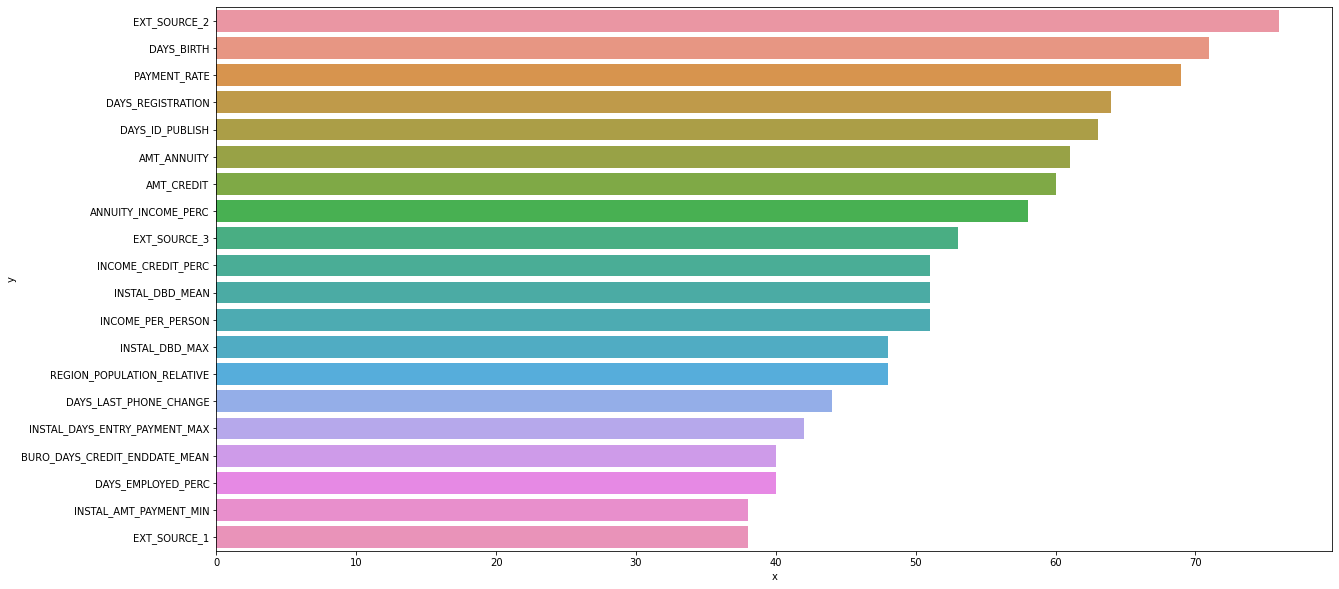

In [ ]:
# top 20 paramètres les plus importants pour le modèle LGBM
bestparams = pd.DataFrame({'x':lgbm_model.feature_importances_,'y':X_test.columns})
bestparams.sort_values(by="x",inplace=True, ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x=bestparams.x[:20],y=bestparams.y[:20])

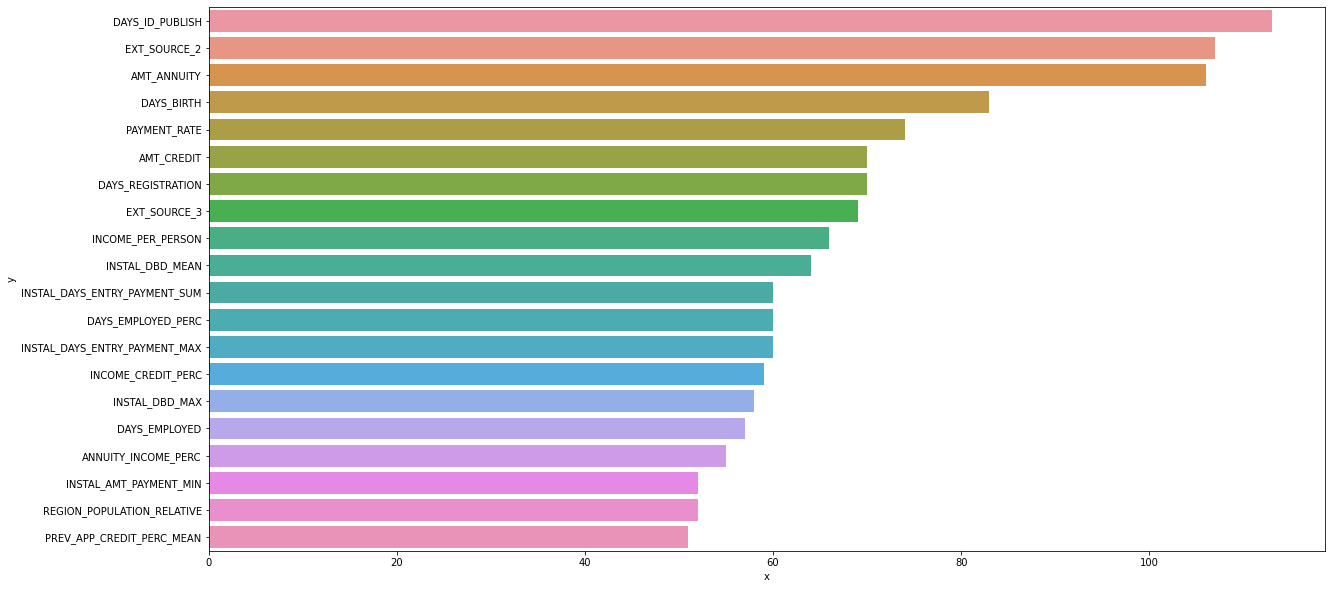

In [ ]:
# top 20 paramètres les plus importants pour le modèle LGBM (bank)
bestparams = pd.DataFrame({'x':lgbm_model_bank.feature_importances_,'y':X_test.columns})
bestparams.sort_values(by="x",inplace=True, ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x=bestparams.x[:20],y=bestparams.y[:20])

###**2. TOP features selon SHAP**

https://www.kaggle.com/dansbecker/shap-values
https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach

La mise en œuvre de SHAP repose sur une méthode d’estimation des valeurs de Shapley.
-         1ère étape de calcul des valeurs de Shapley pour un individu en 
particulier : simuler différentes combinaisons de valeurs pour les variables d’entrée

-         2ème étape : Pour chaque combinaison, calculer la différence entre la valeur prédite et la moyenne des prédictions. La valeur de Shapley d’une variable correspond alors à la moyenne de la contribution de sa valeur en fonction des différentes combinaisons. 

In [ ]:
explainer = shap.TreeExplainer(lgbm_model_bank)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


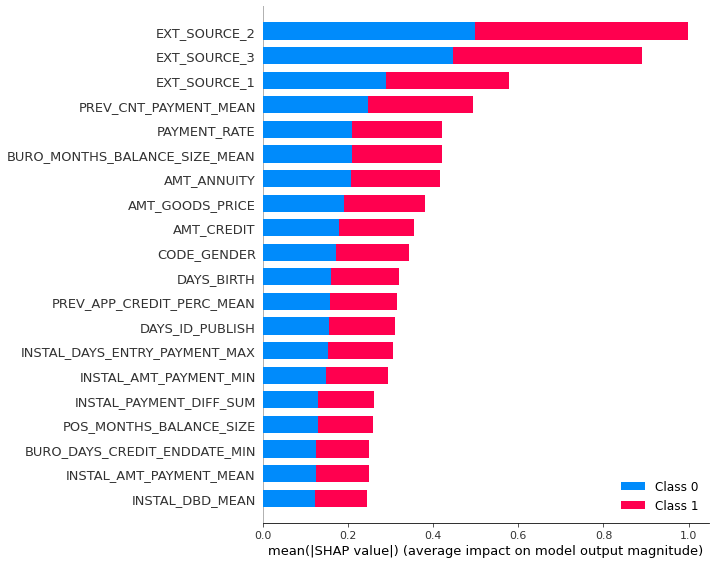

In [70]:
shap.summary_plot(shap_values, X)

 92%|==================  | 915/1000 [00:11<00:01]       

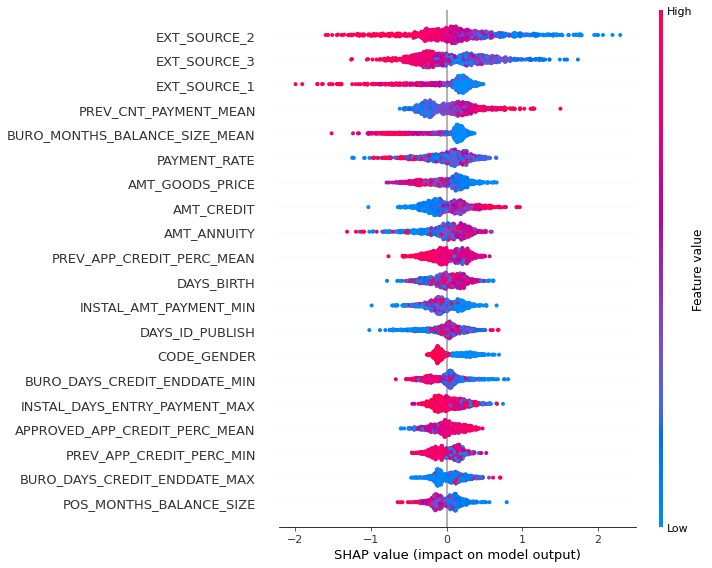

In [76]:
# equilibrated case
background = X.sample(1000) #X is equilibrated 

# background used in explainer defines base value
explainer = shap.TreeExplainer(lgbm_model_bank, background, model_output="raw" )

shap_values = explainer.shap_values(background, check_additivity=False)

#background used in the plot, the points that are visible on the plot

shap.summary_plot(shap_values, background, feature_names=background.columns)

Les variables (SHAP) ayant le plus de poids dans le modèle LightGBM sont : 
- Ex Source2 :	Normalized score from external data source
- INSTAL_PAYMENT_DIFF_MAX
- CODE GENDER : Gender of the client 	


**Sauvegarde du modèle final - banking**

In [ ]:
# modelefinal = "modele_final_Lightgbm_bank.sav"
# pickle.dump(lgbm_model_bank, open('/content/drive/MyDrive/modele_final_Lightgbm_bank.sav', 'wb')) erreur modèle not fitted dans l'api (visual)
with open('/content/drive/MyDrive/modele_final_Lightgbm_bank.sav', "wb") as f:
        pickle.dump(lgbm_model_bank, f)

In [ ]:
lgbm_model_bank.booster_.save_model('/content/drive/MyDrive/modele_final_Lightgbm_bank.sav')

In [ ]:
# import joblib
# joblib.dump(lgbm_model_bank, '/content/drive/MyDrive/modele_final_Lightgbm_bank.sav')

['/content/drive/MyDrive/modele_final_Lightgbm_bank.sav']

In [ ]:
import lightgbm as lgb

----